# **Real Estate Price Prediction**
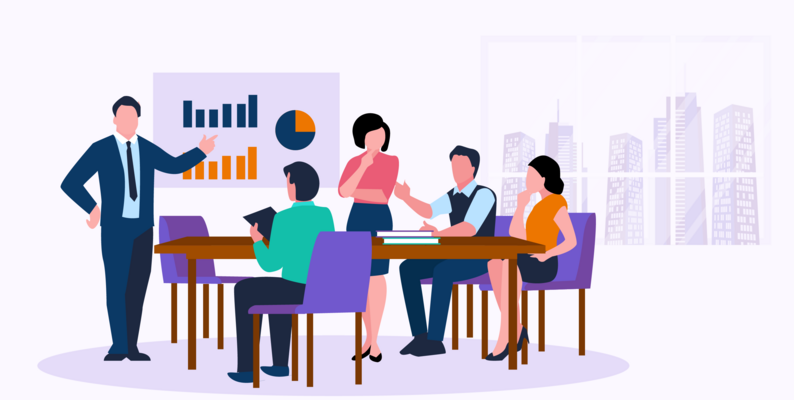

# **Table of Contents**
1. [Introduction](#1)
1. [Import Libraries](#2)
1. [Load and Split Data](#3)
1. [Data Understanding](#4)
1. [Data Preparation](#5)
  * [Drop Outliers](#6)
  * [Check Correlation](#7)
  * [Preprocessing Data](#8)
1. [Modeling](#9)
  * [Polynomial Regression](#10)
  * [XGBRegressor](#11)
  * [Ridge Regression](#12)
  * [Lasso Regression](#13)
1. [Conclusion](#14)

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

<a id="1"></a> <br>
# **1. Introduction**

The dataset we'll be analyzing is the dataset which is scrapped from Immoweb.be in Belgium. It shows the information of each house and appartement to sale. This dataset has 52.077 rows and 20 columns.

#### **Attributes:**
The metadata of the columns:

* "locality" - postal code of the house/appartement
* "type_of_property" - the count of a new bike shares
* "subtype_of_property" - real temperature in C
* "price" - temperature in C "feels like"
* "type_of_sale" - humidity in percentage
* "number_of_rooms" - wind speed in km/h
* "house_area" - category of the weather
* "fully_equipped_kitchen" - boolean field - 1 holiday / 0 non holiday
* "open_fire" - boolean field - 1 if the day is weekend
* "terrace" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
* "terrace_area" - category
* "garden" - category
* "garden_area" - category
* "surface_of_the_land" - category
* "surface_of_the_plot_of_land" - category
* "number_of_facades" - category
* "swimming_pool" - category
* "state_of_the_building" - category
* "construction_year" - category

But in this dataset, we don't have the information related longitude and lattitude of each city. So we use also the [zipcode data of Belgium](https://github.com/jief/zipcode-belgium/blob/master/zipcode-belgium.csv). 

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

<a id="2"></a> <br>
# **2. Imports**

In [ ]:
# Load data libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data preparation
from sklearn.preprocessing import RobustScaler, StandardScaler
from datetime import datetime
import math

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

<a id="3"></a> <br>
# **3. Load and Split the Data**

In [ ]:
# First, let's load the data
df = pd.read_csv("../data/dataset_house_apartment.csv")

df.head()

In [ ]:
df.shape

In [ ]:
# Load zipcode data of Belgium
zipcode = pd.read_csv("../data/code-postaux-belge.csv")

In [ ]:
# Drop empty columns
zipcode.drop(columns=["coordonnees", "geom"], inplace=True)

# Rename the columns
zipcode.rename(
    columns={
        "column_1": "locality",
        "column_2": "city_name",
        "column_3": "lattitude",
        "column_4": "longitude",
    },
    inplace=True,
)

# Drop the localities' duplicates
zipcode.drop_duplicates(subset=["locality"], inplace=True)

In [ ]:
zipcode.shape

Merge real estate data and zipcode data

In [ ]:
dfinal = pd.merge(df, zipcode, on=["locality"], how="inner")

In [ ]:
dfinal.shape

In [ ]:
dfinal.head(5)

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

<a id="4"></a> <br>
# **4. Data Understanding**

In [ ]:
dfinal.info()

Check number of duplicated rows in data and drop these rows

In [ ]:
dfinal.duplicated().sum()

In [ ]:
dfinal.drop_duplicates(inplace=True)

In [ ]:
# rename columns name 'locality' to 'postal_code'

dfinal.rename(columns={"locality": "postal_code"}, inplace=True)

In [ ]:
# Drop columns with only 1 unique value
dfinal.drop(
    columns=["type_of_sale", "furnished", "surface_of_the_plot_of_land"], inplace=True
)
dfinal.shape

In [ ]:
dfinal.describe()

Check misisng values in data

In [ ]:
dfinal.isnull().sum()

In [ ]:
total_missing = dfinal.isna().sum() * 100 / len(df)
print("Percentage Missing Value %")
total_missing

total_missing = dfinal.isna().sum()*100/len(df)
print('Percentage Missing Value %')
total_missing

We have so 51532 instances with 23 different variables to work on.